In [51]:
# importing dependencies
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from ydata_profiling import ProfileReport
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

### Data EDA and understanding

In [3]:
# data loading 
data = pd.read_csv('/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [4]:
# checking the info 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


The total charges isn't in integer or float data type, seeing as it realted to money we'll convert it to float. 

In [5]:
# converting total charges to float
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data['TotalCharges'].dtypes

dtype('float64')

In [6]:
# checking null values
data.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [7]:
# dropping null values 
data.dropna(inplace=True)

In [8]:
# checking the distribution of target values 
data['Churn'].value_counts(normalize=True)

Churn
No     0.734215
Yes    0.265785
Name: proportion, dtype: float64

Text(0.5, 1.0, 'Churn distribution')

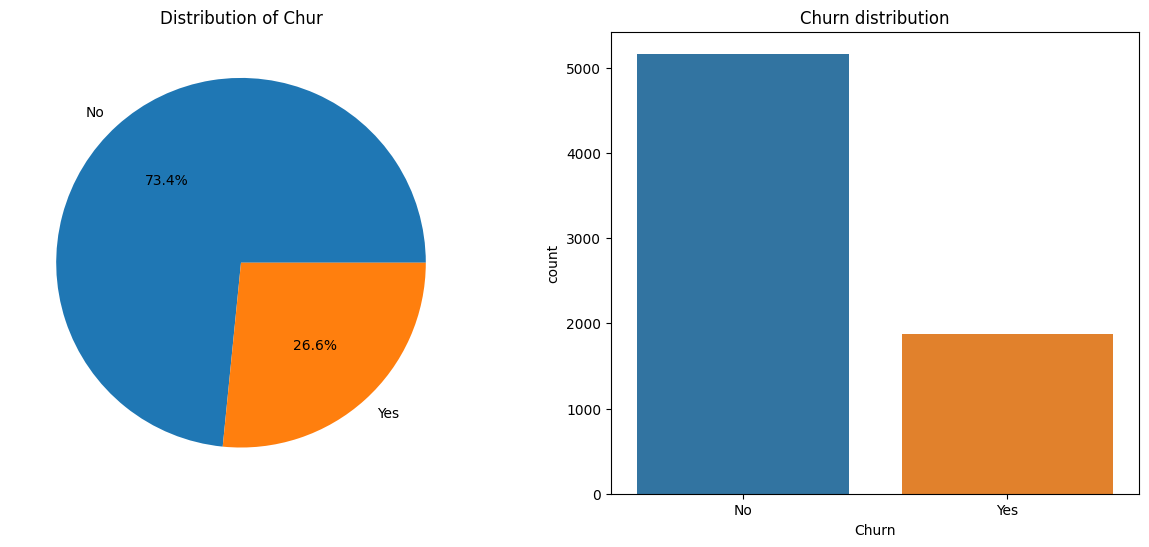

In [9]:
# visualizing the churn distribution 
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
status_counts = data['Churn'].value_counts()
axes[0].pie(status_counts, labels=status_counts.index, autopct='%1.1f%%')
axes[0].set_title('Distribution of Chur')
sns.countplot(x='Churn', data=data, ax=axes[1])
axes[1].set_title('Churn distribution')

We can see that there is a dataset imbalance. There are far few positive values as compared to the negative values. We will solve this using oversampling

Visualizing different numeric values using a pairplot in the dataset

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

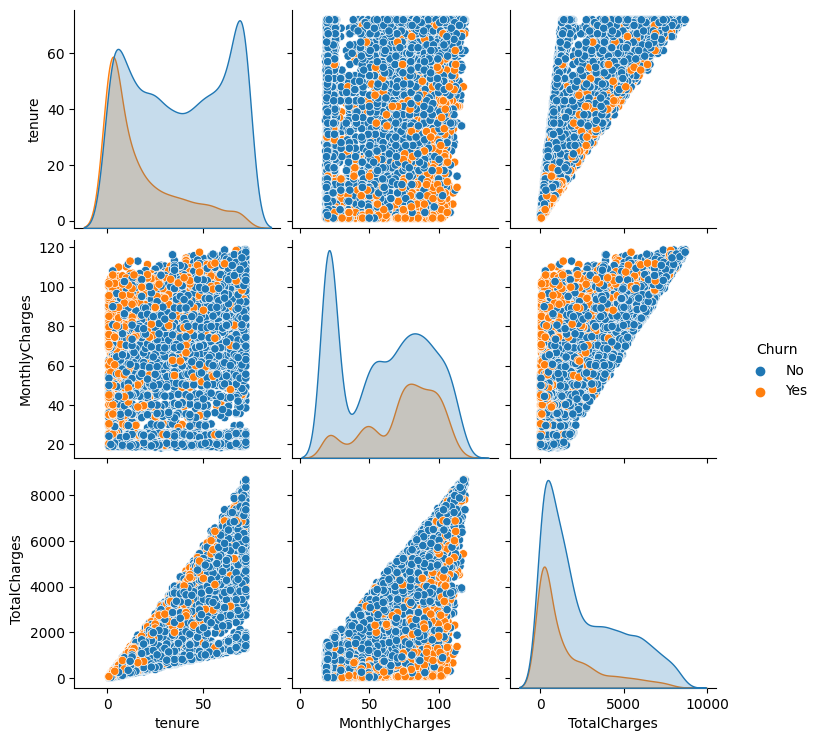

In [10]:
sns.pairplot(data.drop('SeniorCitizen', axis=1), hue='Churn')
# we are dropping this column cause this has only binary values

In [11]:
customer_info = ['SeniorCitizen', 'gender', 'Partner', 'Dependents']

Visualizing customer info through pie charts

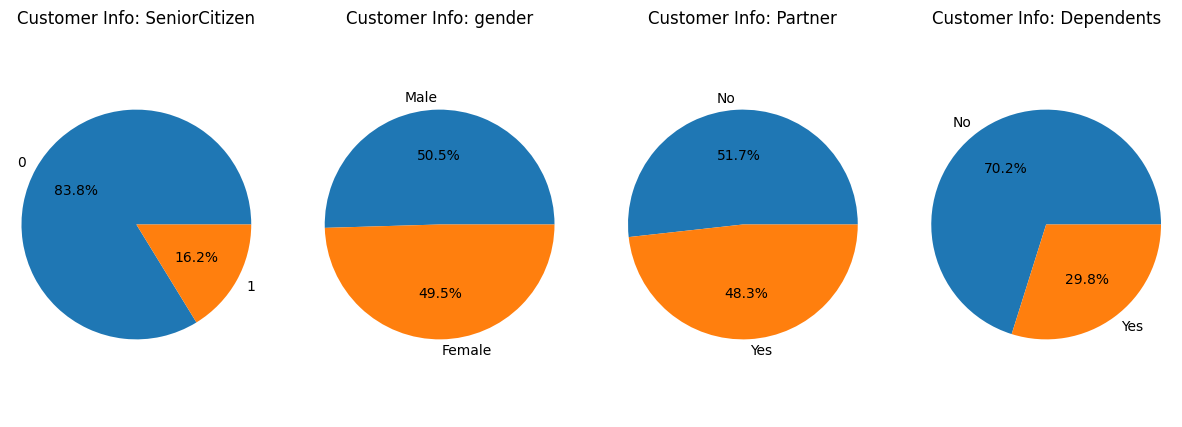

In [12]:
plt.figure(figsize=(15, 5))
for i, col in enumerate(customer_info, 1):
    plt.subplot(1, 4, i)
    counts = data[col].value_counts(normalize=True)
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%')
    plt.title(f'Customer Info: {col}')
    plt.axis('equal')  
plt.show()

Analyzing different categorical values are spread across churn predictions. For eg., how gender distribution is affecting churn values 

In [13]:
categorical = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 
               'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 
               'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

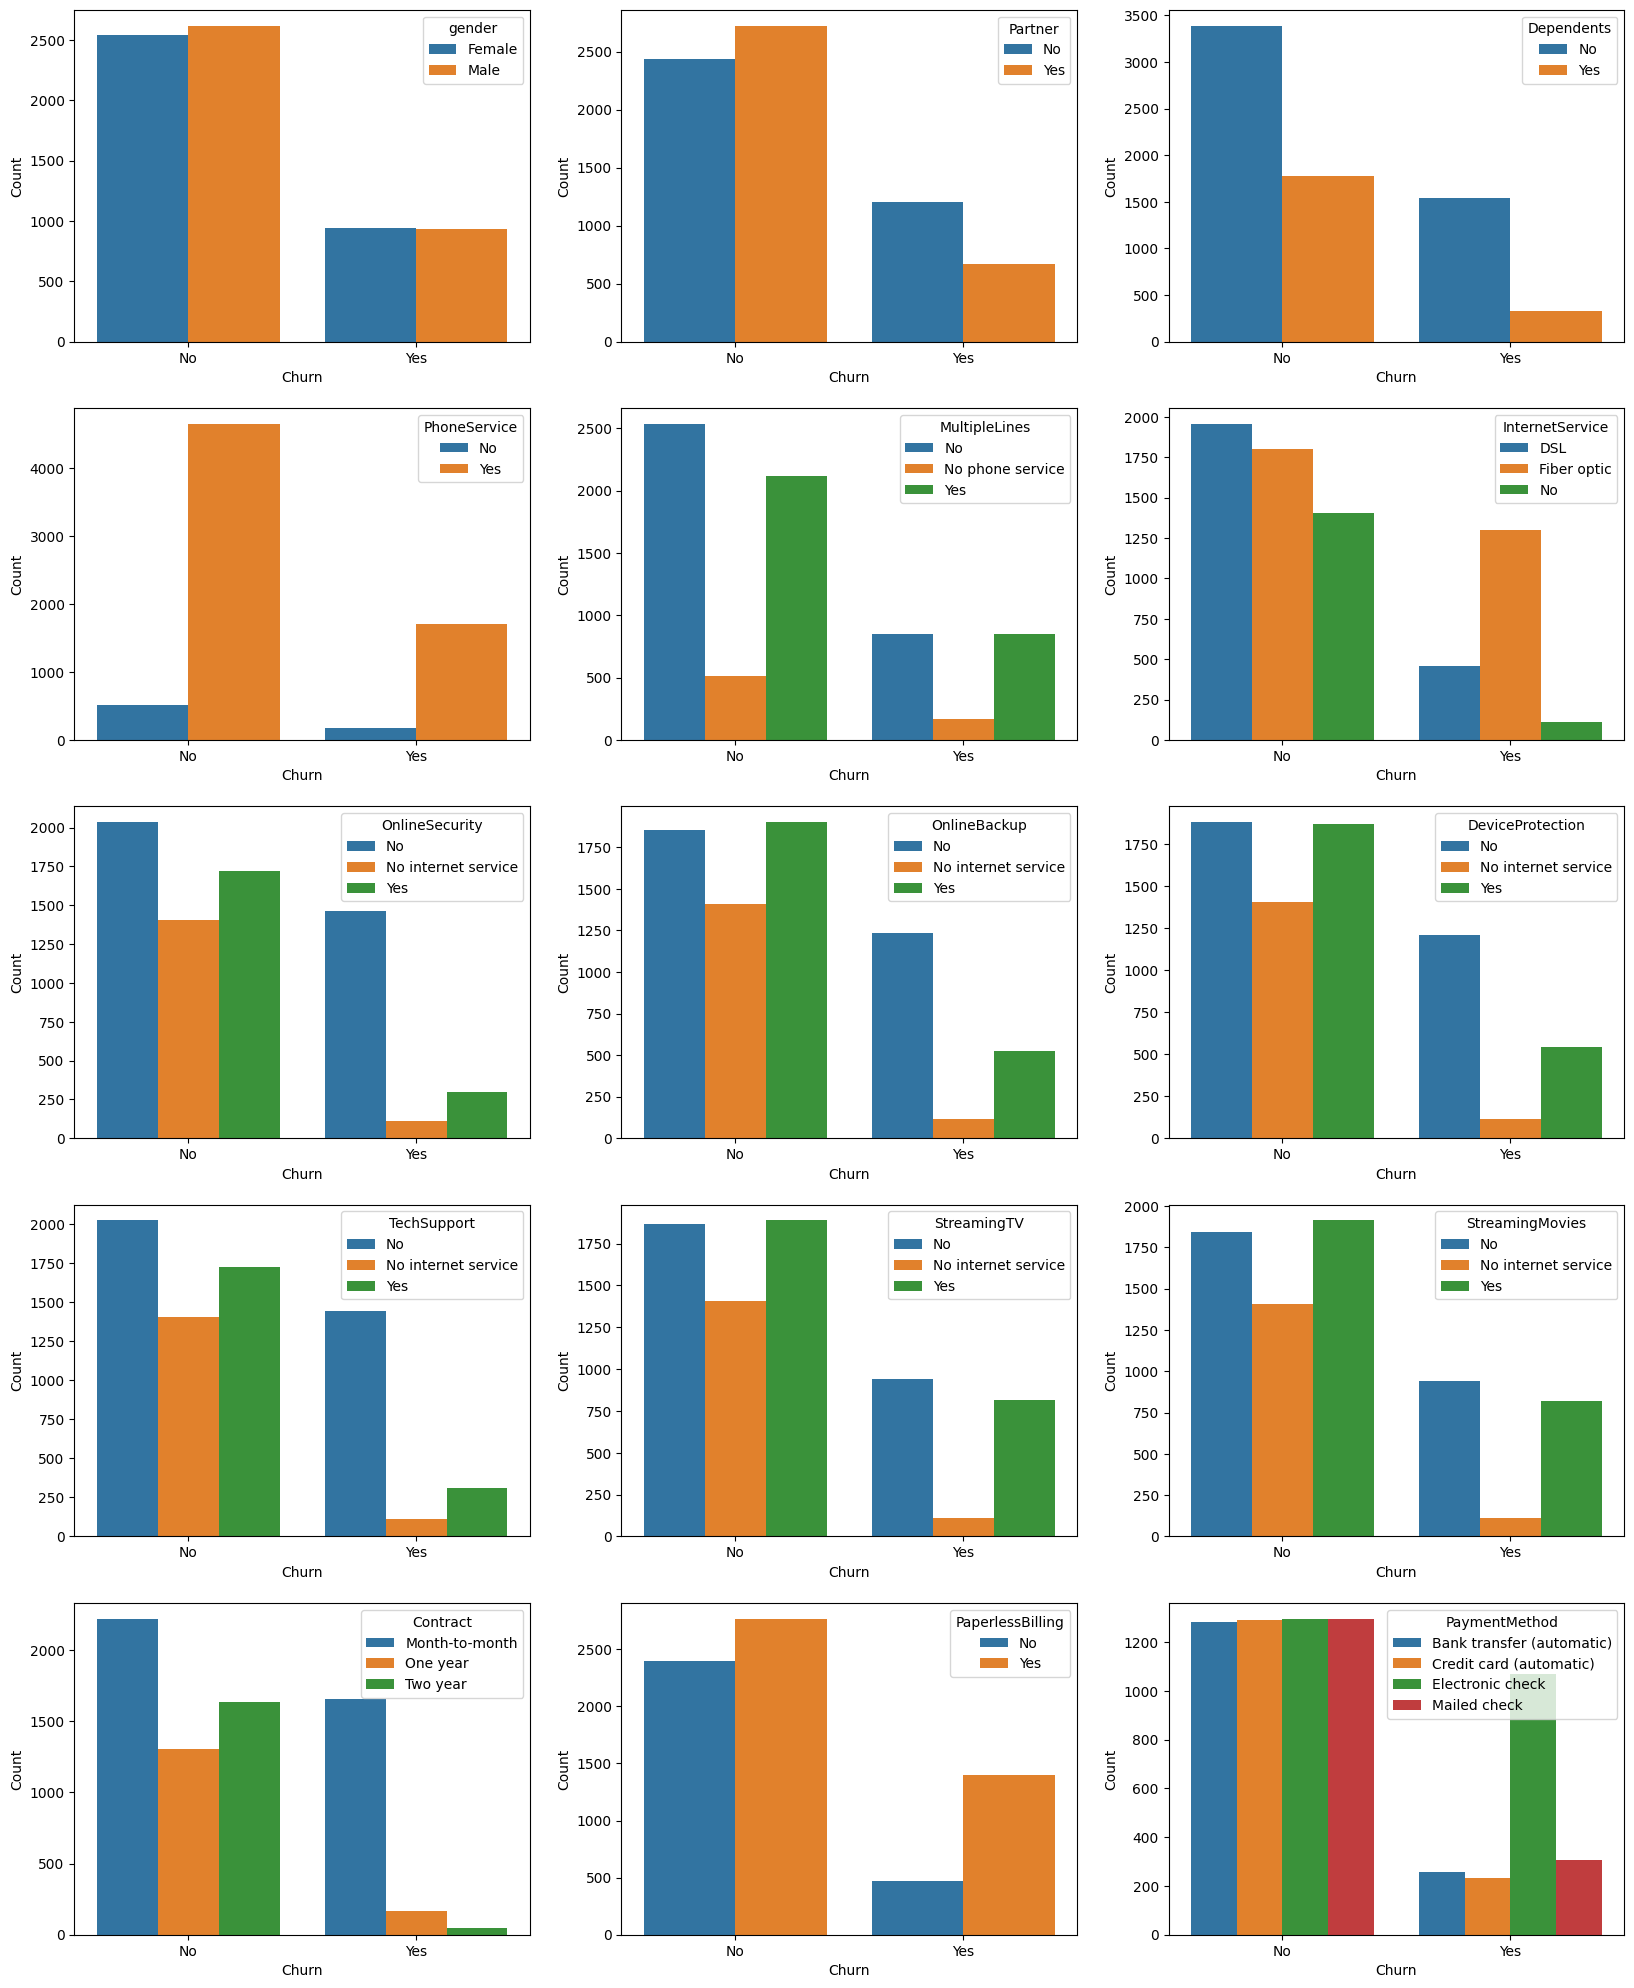

In [14]:
fig, axes = plt.subplots(5,3, figsize=(20, 25))
for i,col in enumerate(categorical,0):
    temp = data.groupby(['Churn',col], as_index=False)['customerID'].count()
    temp.columns = ['Churn', col, 'Count']
    sns.barplot(ax=axes[i//3,i% 3],data=temp, x="Churn", y='Count', hue=col)

Using libraries such as ydata_profiling help us explore more avenues and sometimes help us come across things we might have missed. ydata_profiling is an automated eda library. 

### Data prep for models

In [15]:
# dropping numerical columns
categorical_features = data.drop(['customerID','TotalCharges','MonthlyCharges',
                                  'SeniorCitizen','tenure'], axis=1)
categorical_features.head()

,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
0,Female,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,No
1,Male,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,No
2,Male,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,Yes
3,Male,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),No
4,Female,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,Yes


In [16]:
# using sklearn's label encoder
le = LabelEncoder()
categorical_features = categorical_features.apply(le.fit_transform)

In [17]:
categorical_features.head()

,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
0,0,1,0,0,1,0,0,2,0,0,0,0,0,1,2,0
1,1,0,0,1,0,0,2,0,2,0,0,0,1,0,3,0
2,1,0,0,1,0,0,2,2,0,0,0,0,0,1,3,1
3,1,0,0,0,1,0,2,0,2,2,0,0,1,0,0,0
4,0,0,0,1,0,1,0,0,0,0,0,0,0,1,2,1


In [19]:
# clubbing categorical values and the numerical ones 
num_features = data[['customerID','TotalCharges','MonthlyCharges',
                                  'SeniorCitizen','tenure']]

In [20]:
final_df = pd.concat([num_features, categorical_features], axis='columns')

In [22]:
final_df.head()

,customerID,TotalCharges,MonthlyCharges,SeniorCitizen,tenure,gender,Partner,Dependents,PhoneService,MultipleLines,...,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
0,7590-VHVEG,29.85,29.85,0,1,0,1,0,0,1,...,0,2,0,0,0,0,0,1,2,0
1,5575-GNVDE,1889.50,56.95,0,34,1,0,0,1,0,...,2,0,2,0,0,0,1,0,3,0
2,3668-QPYBK,108.15,53.85,0,2,1,0,0,1,0,...,2,2,0,0,0,0,0,1,3,1
3,7795-CFOCW,1840.75,42.30,0,45,1,0,0,0,1,...,2,0,2,2,0,0,1,0,0,0
4,9237-HQITU,151.65,70.70,0,2,0,0,0,1,0,...,0,0,0,0,0,0,0,1,2,1


In [23]:
# dropping customerID because it is of no use 
final_df.drop('customerID', axis=1, inplace=True)
final_df.head()

,TotalCharges,MonthlyCharges,SeniorCitizen,tenure,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
0,29.85,29.85,0,1,0,1,0,0,1,0,0,2,0,0,0,0,0,1,2,0
1,1889.50,56.95,0,34,1,0,0,1,0,0,2,0,2,0,0,0,1,0,3,0
2,108.15,53.85,0,2,1,0,0,1,0,0,2,2,0,0,0,0,0,1,3,1
3,1840.75,42.30,0,45,1,0,0,0,1,0,2,0,2,2,0,0,1,0,0,0
4,151.65,70.70,0,2,0,0,0,1,0,1,0,0,0,0,0,0,0,1,2,1


In [24]:
# normalizing total charges, and monthly charges
scaler = MinMaxScaler()

In [28]:
final_df['MonthlyCharges'] = scaler.fit_transform(np.array(final_df['MonthlyCharges']).reshape(-1,1))
final_df['TotalCharges'] = scaler.fit_transform(np.array(final_df['TotalCharges']).reshape(-1,1))

In [31]:
# splitting data into X, y
X = final_df.drop('Churn', axis=1)
y = final_df['Churn']

In [33]:
# train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
(len(X_train), len(y_train)), (len(X_test), len(y_test))

((4922, 4922), (2110, 2110))

### Oversampling to make the data imbalance equal 

In [34]:
oversample = SMOTE(k_neighbors=5)
X_smote, y_smote = oversample.fit_resample(X_train, y_train)

In [35]:
X_train, y_train = X_smote, y_smote

In [37]:
y_train.value_counts()

Churn
0    3596
1    3596
Name: count, dtype: int64

We can now see that our data is balanced 

### Model selection and training

We will choose three models and compare how they perform with each other: 
1. Logistic regression
2. Gradient Boosting classifier 
3. random forests
4. SVMs

1. Random forest Classifier

In [44]:
rf_model = RandomForestClassifier()

In [45]:
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)
rf_acc = accuracy_score(rf_preds, y_test)
print(f"The accuracy of Random Forest classifier is: {rf_acc}")
print(classification_report(y_test, rf_preds))

The accuracy of Random Forest classifier is: 0.7791469194312797
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      1567
           1       0.56      0.64      0.60       543

    accuracy                           0.78      2110
   macro avg       0.72      0.73      0.72      2110
weighted avg       0.79      0.78      0.78      2110



2. Logistic regression model

In [46]:
log_model = LogisticRegression()

In [47]:
log_model.fit(X_train, y_train)
log_preds = log_model.predict(X_test)
log_acc = accuracy_score(rf_preds, y_test)
print(f"The accuracy of Logistic Regression classifier is: {log_acc}")
print(classification_report(y_test, log_preds))

The accuracy of Logistic Regression classifier is: 0.7791469194312797
              precision    recall  f1-score   support

           0       0.90      0.75      0.81      1567
           1       0.51      0.76      0.61       543

    accuracy                           0.75      2110
   macro avg       0.70      0.75      0.71      2110
weighted avg       0.80      0.75      0.76      2110



/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


3. Gradient Boost classifier

In [49]:
gb_model = GradientBoostingClassifier()

In [50]:
gb_model.fit(X_train, y_train)
gb_preds = gb_model.predict(X_test)
gb_acc = accuracy_score(gb_preds, y_test)
print(f"The accuracy of Gradient boosting classifier is: {gb_acc}")
print(classification_report(y_test, gb_preds))

The accuracy of Gradient boosting classifier is: 0.7601895734597156
              precision    recall  f1-score   support

           0       0.90      0.77      0.83      1567
           1       0.52      0.74      0.61       543

    accuracy                           0.76      2110
   macro avg       0.71      0.75      0.72      2110
weighted avg       0.80      0.76      0.77      2110



4. SVC

In [53]:
svc_model = SVC()

In [54]:
svc_model.fit(X_train, y_train)
svc_preds = rf_model.predict(X_test)
svc_acc = accuracy_score(svc_preds, y_test)
print(f"The accuracy of SVC is: {svc_acc}")
print(classification_report(y_test, rf_preds))

The accuracy of SVC is: 0.7791469194312797
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      1567
           1       0.56      0.64      0.60       543

    accuracy                           0.78      2110
   macro avg       0.72      0.73      0.72      2110
weighted avg       0.79      0.78      0.78      2110

